In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.patches as mpatches



In [61]:
#1. Download the database from [https://drive.google.com/drive/folders/1ZVG-co0r0smof4aisFQiyo5eEoF8Zi-R?usp=sharing].
#2. Place the file in the same folder as this notebook.
#3. Run the cells below.

con = duckdb.connect("gender_db.duckdb") 

In [62]:
con.query(""" SHOW TABLES;""")

┌──────────────────────────────────┐
│               name               │
│             varchar              │
├──────────────────────────────────┤
│ big_table_eu                     │
│ big_table_us                     │
│ gender_term_health_sciences_eu   │
│ gender_term_health_sciences_us   │
│ gender_term_life_sciences_eu     │
│ gender_term_life_sciences_us     │
│ gender_term_physical_sciences_eu │
│ gender_term_physical_sciences_us │
│ gender_term_social_sciences_eu   │
│ gender_term_social_sciences_us   │
│ gender_year_health_sciences_eu   │
│ gender_year_health_sciences_us   │
│ gender_year_life_sciences_eu     │
│ gender_year_life_sciences_us     │
│ gender_year_physical_sciences_eu │
│ gender_year_physical_sciences_us │
│ gender_year_social_sciences_eu   │
│ gender_year_social_sciences_us   │
│ sample_for_labeling              │
├──────────────────────────────────┤
│             19 rows              │
└──────────────────────────────────┘

In [63]:
# Get schema information for the specific table
con.query("DESCRIBE big_table_us;")

┌───────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│        column_name        │ column_type │  null   │   key   │ default │  extra  │
│          varchar          │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ work_id                   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ title                     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ publication_year          │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ country_codes             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ primary_author_name       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ primary_author_id         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ primary_author_first_name │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ primary_author_gender     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NU

In [64]:
# --- EU Data ---
# Get total records
total_eu = con.query("SELECT COUNT(*) FROM big_table_eu").fetchone()[0]
# Get unknown gender records
unknown_eu = con.query("SELECT COUNT(*) FROM big_table_eu WHERE primary_author_gender = 'unknown'").fetchone()[0]

# --- US Data ---
# Get total records
total_us = con.query("SELECT COUNT(*) FROM big_table_us").fetchone()[0]
# Get unknown gender records
unknown_us = con.query("SELECT COUNT(*) FROM big_table_us WHERE primary_author_gender = 'unknown'").fetchone()[0]

# --- Print Results ---
print(f"Total Data (EU):     {total_eu:,}")
print(f"Total Unknown (EU):  {unknown_eu:,}")
print("-" * 30)
print(f"Total Data (US):     {total_us:,}")
print(f"Total Unknown (US):  {unknown_us:,}")

Total Data (EU):     27,157,254
Total Unknown (EU):  4,514,981
------------------------------
Total Data (US):     27,973,377
Total Unknown (US):  4,388,132


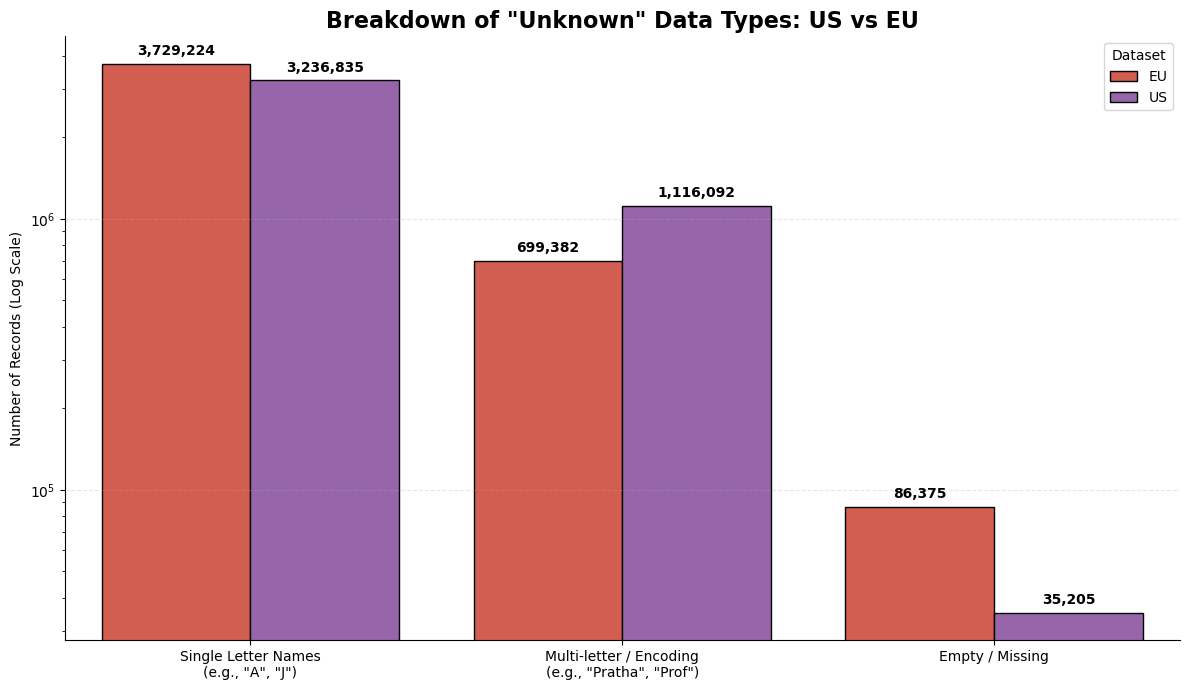

In [65]:
# 1. Get stats for EU Data
# Empty names
eu_empty = con.query("""
    SELECT COUNT(*) FROM big_table_eu 
    WHERE primary_author_gender = 'unknown' 
    AND (primary_author_first_name IS NULL OR TRIM(primary_author_first_name) = '')
""").fetchone()[0]

# Single letter names
eu_single = con.query("""
    SELECT COUNT(*) FROM big_table_eu 
    WHERE primary_author_gender = 'unknown' 
    AND LENGTH(primary_author_first_name) = 1
""").fetchone()[0]

# Multi-letter (Encoding/Prof/etc)
eu_total = con.query("SELECT COUNT(*) FROM big_table_eu WHERE primary_author_gender = 'unknown'").fetchone()[0]
eu_multi = eu_total - eu_empty - eu_single


# 2. Get stats for US Data
# Empty names
us_empty = con.query("""
    SELECT COUNT(*) FROM big_table_us 
    WHERE primary_author_gender = 'unknown' 
    AND (primary_author_first_name IS NULL OR TRIM(primary_author_first_name) = '')
""").fetchone()[0]

# Single letter names
us_single = con.query("""
    SELECT COUNT(*) FROM big_table_us 
    WHERE primary_author_gender = 'unknown' 
    AND LENGTH(primary_author_first_name) = 1
""").fetchone()[0]

# Multi-letter
us_total = con.query("SELECT COUNT(*) FROM big_table_us WHERE primary_author_gender = 'unknown'").fetchone()[0]
us_multi = us_total - us_empty - us_single


# 3. Create the table for plotting
data = {
    'Category': [
        'Single Letter Names\n(e.g., "A", "J")', 'Single Letter Names\n(e.g., "A", "J")',
        'Multi-letter / Encoding\n(e.g., "Pratha", "Prof")', 'Multi-letter / Encoding\n(e.g., "Pratha", "Prof")',
        'Empty / Missing', 'Empty / Missing'
    ],
    'Region': ['EU', 'US', 'EU', 'US', 'EU', 'US'],
    'Count': [eu_single, us_single, eu_multi, us_multi, eu_empty, us_empty]
}
df_comp = pd.DataFrame(data)

# 4. Make the chart
plt.figure(figsize=(12, 7))

sns.barplot(
    data=df_comp,
    x='Category',
    y='Count',
    hue='Region',
    palette=['#E74C3C', '#9B59B6'], # Red for EU, Purple for US
    edgecolor='black'
)

# Add the numbers on top
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().text(
            p.get_x() + p.get_width()/2, 
            height + (height * 0.05), 
            f'{int(height):,}', 
            ha='center', va='bottom', fontweight='bold'
        )

# Titles and labels
plt.title('Breakdown of "Unknown" Data Types: US vs EU', fontsize=16, fontweight='bold')
plt.ylabel('Number of Records (Log Scale)')
plt.xlabel('')
plt.yscale('log') # Log scale helps see small numbers better
plt.legend(title='Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Remove the border box
sns.despine()

plt.tight_layout()
plt.show()

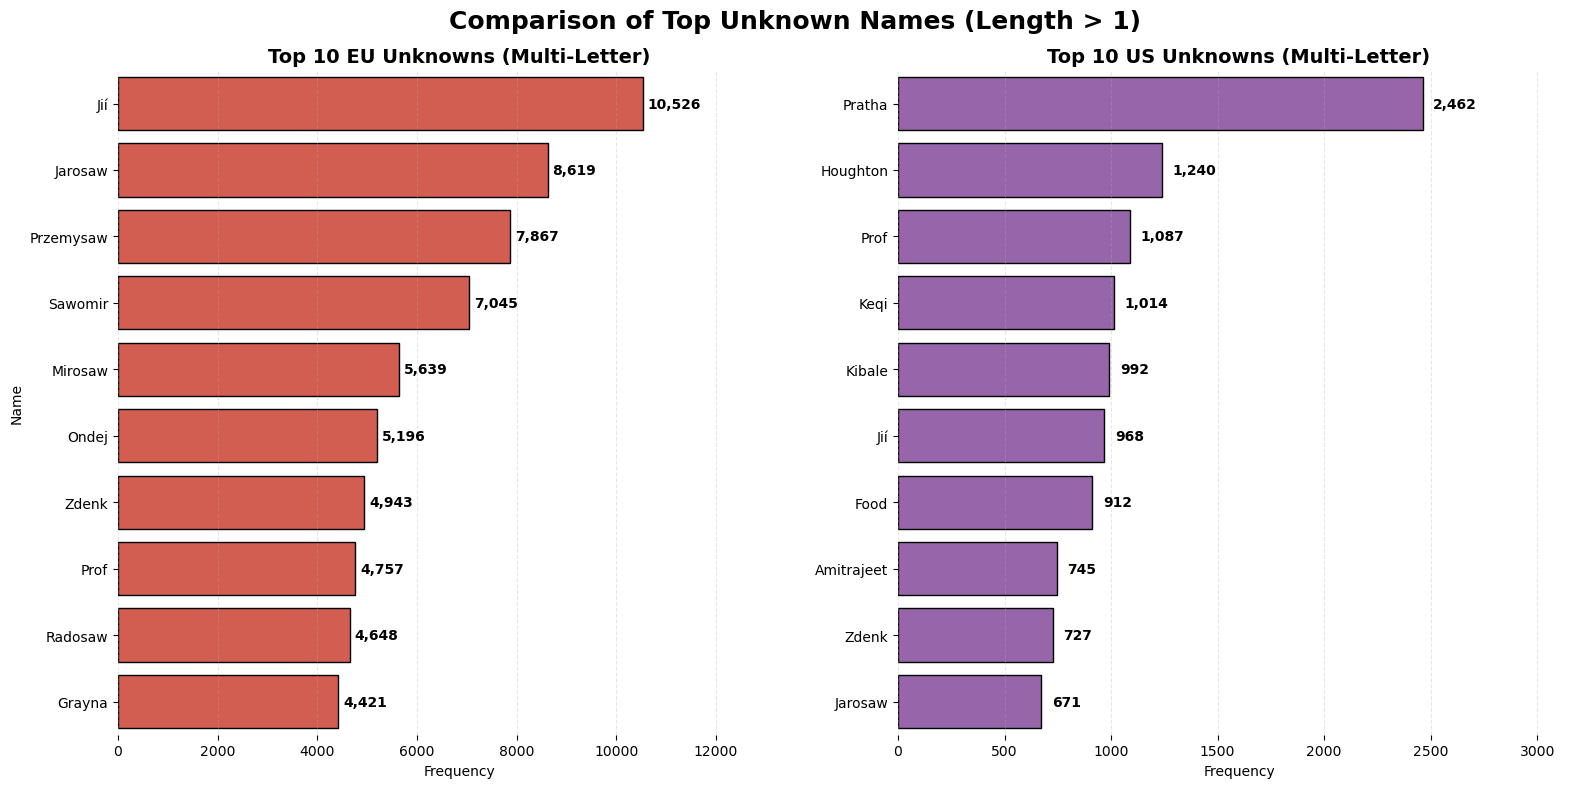

--- Top 10 EU (Multi-Letter) ---
primary_author_first_name  count
                      Jií  10526
                  Jarosaw   8619
                Przemysaw   7867
                  Sawomir   7045
                  Mirosaw   5639
                    Ondej   5196
                    Zdenk   4943
                     Prof   4757
                  Radosaw   4648
                   Grayna   4421

--- Top 10 US (Multi-Letter) ---
primary_author_first_name  count
                   Pratha   2462
                 Houghton   1240
                     Prof   1087
                     Keqi   1014
                   Kibale    992
                      Jií    968
                     Food    912
               Amitrajeet    745
                    Zdenk    727
                  Jarosaw    671


In [66]:
# 1. Get Top 10 EU names (Length > 1 only)
query_eu = """
    SELECT primary_author_first_name, COUNT(*) as count 
    FROM big_table_eu 
    WHERE primary_author_gender = 'unknown' 
    AND LENGTH(TRIM(primary_author_first_name)) > 1
    GROUP BY primary_author_first_name 
    ORDER BY count DESC 
    LIMIT 10
"""
top10_eu = con.query(query_eu).df()

# 2. Get Top 10 US names (Length > 1 only)
query_us = """
    SELECT primary_author_first_name, COUNT(*) as count 
    FROM big_table_us 
    WHERE primary_author_gender = 'unknown' 
    AND LENGTH(TRIM(primary_author_first_name)) > 1
    GROUP BY primary_author_first_name 
    ORDER BY count DESC 
    LIMIT 10
"""
top10_us = con.query(query_us).df()

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- EU Plot ---
sns.barplot(
    data=top10_eu, 
    y='primary_author_first_name', 
    x='count', 
    ax=axes[0], 
    color='#E74C3C',
    edgecolor='black'
)
axes[0].set_xlim(0, top10_eu['count'].max() * 1.3)
axes[0].set_title('Top 10 EU Unknowns (Multi-Letter)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Name')
axes[0].grid(axis='x', linestyle='--', alpha=0.3)

for i, (count, name) in enumerate(zip(top10_eu['count'], top10_eu['primary_author_first_name'])):
    axes[0].text(count + 100, i, f'{count:,}', va='center', fontweight='bold')

# --- US Plot ---
sns.barplot(
    data=top10_us, 
    y='primary_author_first_name', 
    x='count', 
    ax=axes[1], 
    color='#9B59B6',
    edgecolor='black'
)
axes[1].set_xlim(0, top10_us['count'].max() * 1.3)
axes[1].set_title('Top 10 US Unknowns (Multi-Letter)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('') 
axes[1].grid(axis='x', linestyle='--', alpha=0.3)

for i, (count, name) in enumerate(zip(top10_us['count'], top10_us['primary_author_first_name'])):
    axes[1].text(count + 50, i, f'{count:,}', va='center', fontweight='bold')

plt.suptitle('Comparison of Top Unknown Names (Length > 1)', fontsize=18, fontweight='bold', y=0.98)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

# Print for verification
print("--- Top 10 EU (Multi-Letter) ---")
print(top10_eu.to_string(index=False))
print("\n--- Top 10 US (Multi-Letter) ---")
print(top10_us.to_string(index=False))

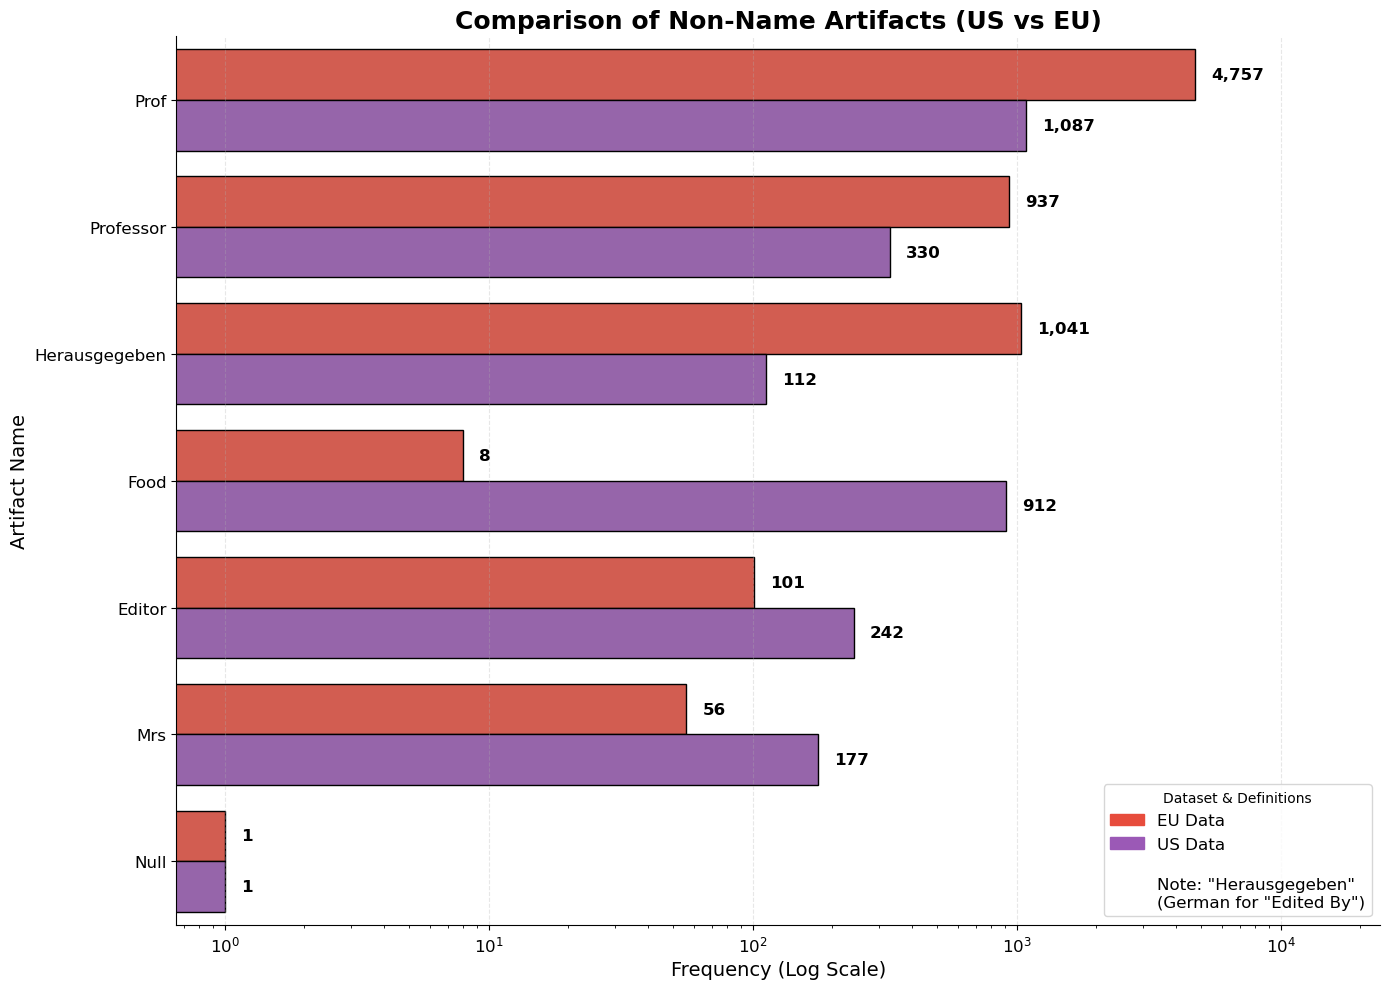

In [67]:

non_name_list = [
    'Prof', 'Dr', 'Mr', 'Mrs', 'Ms', 'PhD', 'Editorial', 
    'Staff', 'Author', 'Herausgegeben', 'Editor', 'Guest', 
    'Professor', 'N/A', 'Null', 'Food'
]
non_name_sql = ", ".join([f"'{x}'" for x in non_name_list])

# 2. Get counts from EU
query_eu = f"""
    SELECT primary_author_first_name, COUNT(*) as count 
    FROM big_table_eu 
    WHERE primary_author_gender = 'unknown' 
    AND primary_author_first_name IN ({non_name_sql})
    GROUP BY primary_author_first_name
"""
df_eu = con.query(query_eu).df()
df_eu['Region'] = 'EU'

# 3. Get counts from US
query_us = f"""
    SELECT primary_author_first_name, COUNT(*) as count 
    FROM big_table_us 
    WHERE primary_author_gender = 'unknown' 
    AND primary_author_first_name IN ({non_name_sql})
    GROUP BY primary_author_first_name
"""
df_us = con.query(query_us).df()
df_us['Region'] = 'US'

# 4. Combine and Sort
df_combined = pd.concat([df_eu, df_us])
total_counts = df_combined.groupby('primary_author_first_name')['count'].sum().sort_values(ascending=False)
sorted_order = total_counts.index.tolist()

# 5. Plot Grouped Bar Chart
plt.figure(figsize=(14, 10))

sns.barplot(
    data=df_combined,
    y='primary_author_first_name',
    x='count',
    hue='Region',
    order=sorted_order,
    palette=['#E74C3C', '#9B59B6'], # Red (EU), Purple (US)
    edgecolor='black'
)

# Log Scale
plt.xscale('log')

# Add labels (BIGGER FONT HERE)
for p in plt.gca().patches:
    width = p.get_width()
    if width > 0:
        plt.gca().text(
            width * 1.15, 
            p.get_y() + p.get_height()/2, 
            f'{int(width):,}', 
            ha='left', 
            va='center', 
            fontweight='bold', 
            fontsize=12, 
            color='black'
        )

eu_patch = mpatches.Patch(color='#E74C3C', label='EU Data')
us_patch = mpatches.Patch(color='#9B59B6', label='US Data')
note_german = mpatches.Patch(color='none', label='\nNote: "Herausgegeben"\n(German for "Edited By")')

plt.legend(
    handles=[eu_patch, us_patch, note_german], 
    title='Dataset & Definitions',
    loc='lower right',
    fontsize=12
)

plt.title('Comparison of Non-Name Artifacts (US vs EU)', fontsize=18, fontweight='bold')
plt.xlabel('Frequency (Log Scale)', fontsize=14)
plt.ylabel('Artifact Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.xlim(right=df_combined['count'].max() * 5) 

sns.despine()
plt.tight_layout()
plt.show()

In [68]:
# Query to find the row where the name is literally written as the text "Null"
con.query("""
    SELECT * FROM big_table_eu 
    WHERE primary_author_gender = 'unknown' 
      AND primary_author_first_name = 'Null';
""").show()

┌──────────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────┬───────────────┬───────────────────────┬──────────────────────────────────┬───────────────────────────┬───────────────────────┬──────────────────┬──────────────────────────────────┬────────────────────────┬────────────────────┬──────────────────────────────────┬────────────────────────────────────────────────────────────┬───────────────────┬─────────────────────┐
│             work_id              │                                               title                                                │ publication_year │ country_codes │  primary_author_name  │        primary_author_id         │ primary_author_first_name │ primary_author_gender │ last_author_name │          last_author_id          │ last_author_first_name │ last_author_gender │            source_id             │                        source_name                         

In [69]:
# ==============================================================================
#  COMPARISON: EU vs US DATA
# ==============================================================================
#
# 1. EU Findings: "Broken Letters"
#    - The EU data is almost all real people. The only problem is that the computer
#      failed to save special letters (like accents).
#    - Example: 'Jarosław' became 'Jarosaw'.
#
# 2. US Findings: "A Messy Mix"
#    - The US data is much harder to fix because it has mixed errors:
#      a. Broken letters (same as EU).
#      b. Unknown Names: Valid Asian/Indian names that the tool just didn't know.

# ==============================================================================

In [70]:
con.close()